# **Import libraries**

In [20]:
# !pip install reparo

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import kagglehub
from kagglehub import KaggleDatasetAdapter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from reparo import PMM, MICE, KNNImputer, HotDeckImputation, FRNNI, CDI, SICE
from sklearn.impute import SimpleImputer
import warnings

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
sns.set_palette('viridis')
sns.color_palette(palette='viridis')

[(0.275191, 0.194905, 0.496005),
 (0.212395, 0.359683, 0.55171),
 (0.153364, 0.497, 0.557724),
 (0.122312, 0.633153, 0.530398),
 (0.288921, 0.758394, 0.428426),
 (0.626579, 0.854645, 0.223353)]

# **Load Dataset**

[Chosen Dataset](https://www.kaggle.com/datasets/altavish/boston-housing-dataset)

In [5]:
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "altavish/boston-housing-dataset",
  "HousingData.csv"
)

100%|██████████| 34.2k/34.2k [00:00<00:00, 28.1MB/s]


# **Analyse Dataset**

In [6]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


I will delete NaN values from target column, as it would be bothersome to restore it, because it may affect the score performance of the models.

In [7]:
df = df[df['CHAS'].notna()]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 486 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     467 non-null    float64
 1   ZN       466 non-null    float64
 2   INDUS    467 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      486 non-null    float64
 5   RM       486 non-null    float64
 6   AGE      466 non-null    float64
 7   DIS      486 non-null    float64
 8   RAD      486 non-null    int64  
 9   TAX      486 non-null    int64  
 10  PTRATIO  486 non-null    float64
 11  B        486 non-null    float64
 12  LSTAT    467 non-null    float64
 13  MEDV     486 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 57.0 KB


In [9]:
df.isna().sum()

,0
CRIM,19
ZN,20
INDUS,19
CHAS,0
NOX,0
RM,0
AGE,20
DIS,0
RAD,0
TAX,0


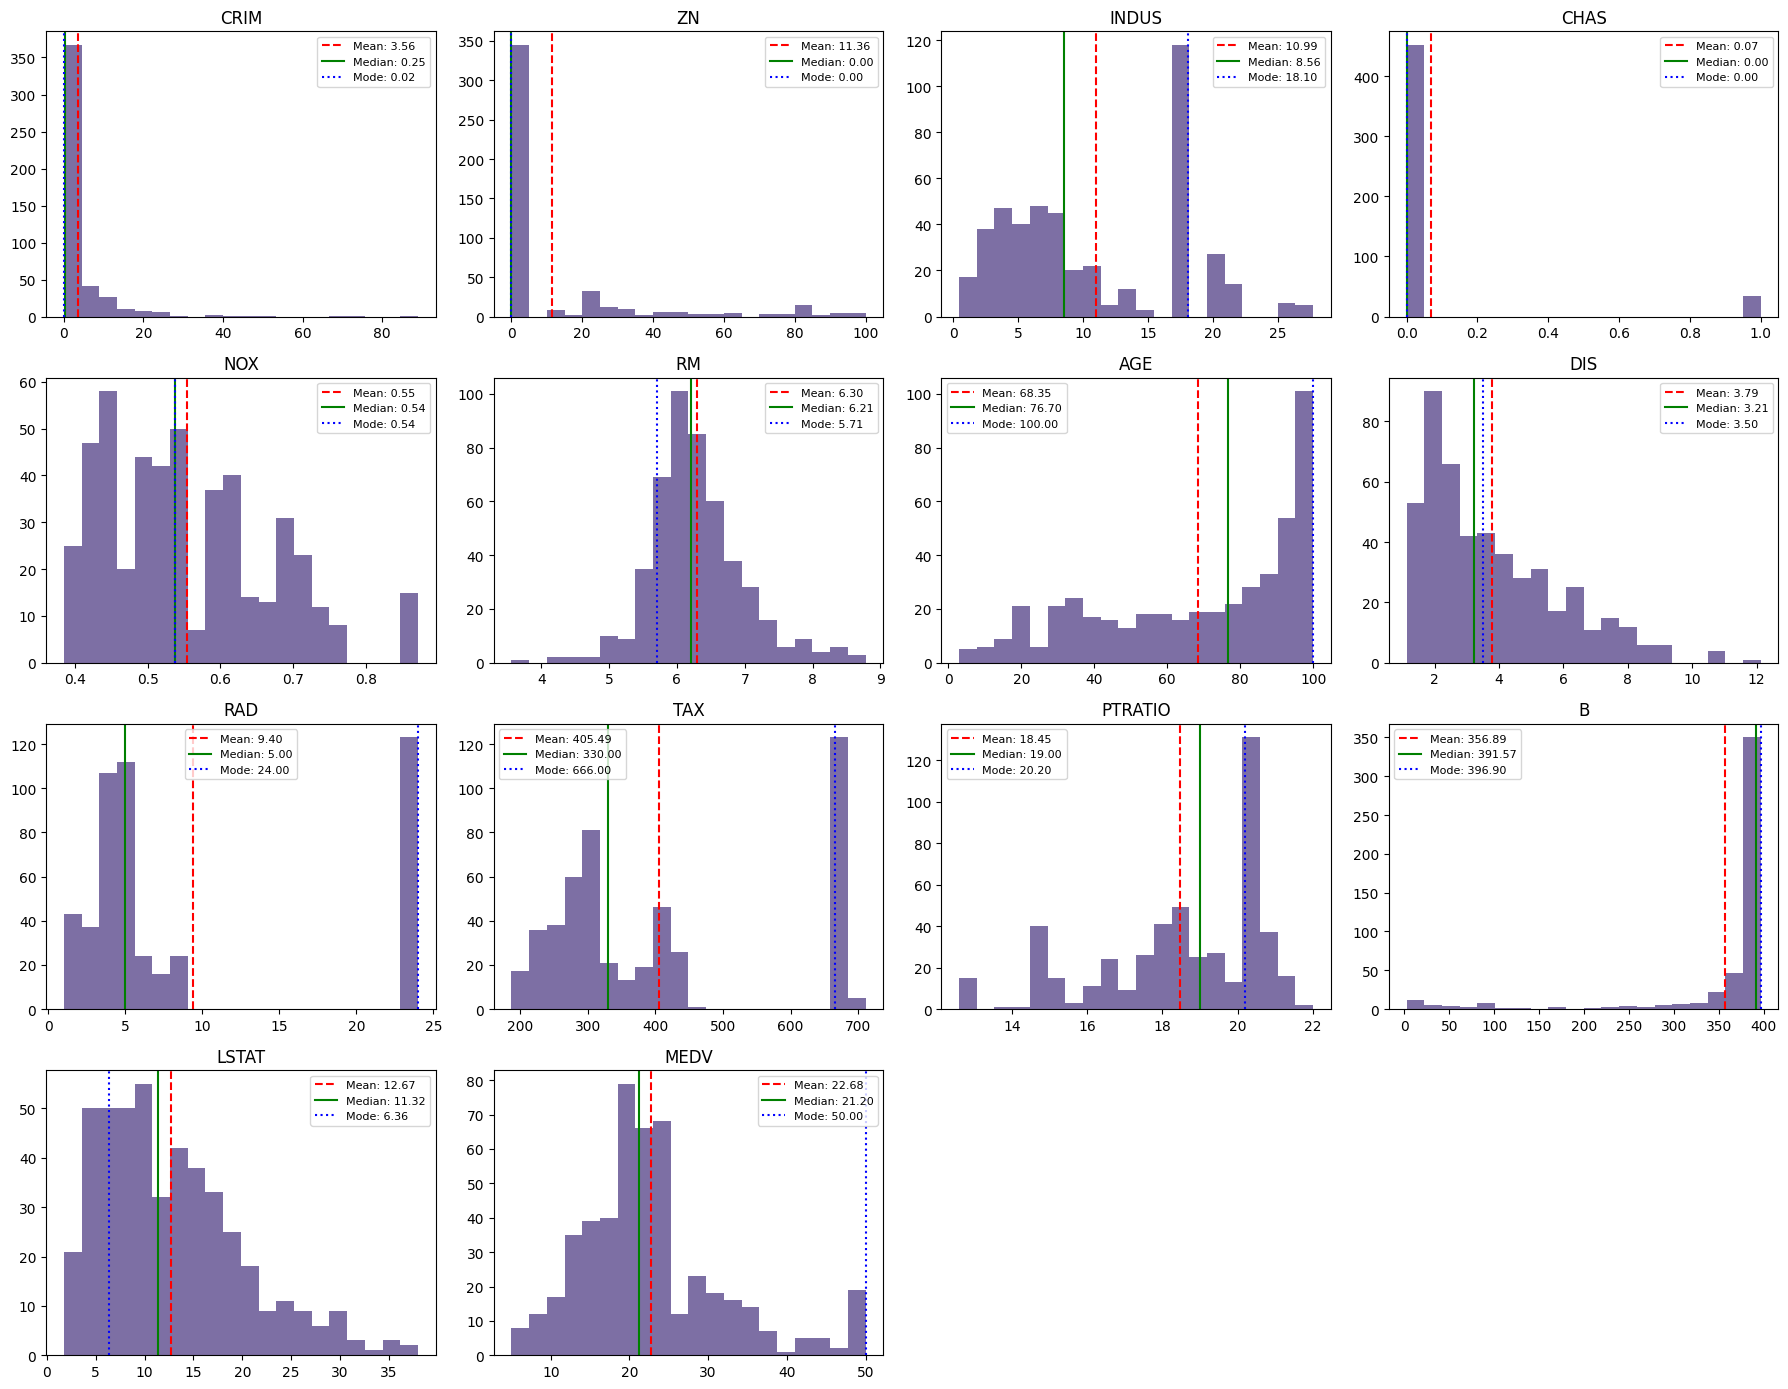

In [10]:
n_cols = 4
n_rows = int(np.ceil(len(df.columns) / n_cols))

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 14))
axs = axs.flatten()

for col, ax in zip(df.columns, axs):
    data = df[col].dropna()

    ax.hist(data, bins=20, alpha=0.7)

    mean = data.mean()
    median = data.median()
    mode = data.mode()
    if len(mode) > 0:
        mode = mode.iloc[0]
    else:
        mode = np.nan

    ax.axvline(mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean:.2f}')
    ax.axvline(median, color='green', linestyle='solid', linewidth=1.5, label=f'Median: {median:.2f}')
    ax.axvline(mode, color='blue', linestyle='dotted', linewidth=1.5, label=f'Mode: {mode:.2f}')

    ax.set_title(col)
    ax.legend(fontsize=8)

for ax in axs[len(df.columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Let's look at data distribution. Almost all of the data is  skewed(except TAX, which looks pretty good).
Mode, mean imputation might be bad...

# **Split Dataset**

In [11]:
X = df.drop('CHAS', axis=1)
y = df['CHAS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Handle Missing Values**

In [12]:
X_trains = []
X_tests = []

In [13]:
imputers = [
    SimpleImputer(),
    SimpleImputer(strategy='median'),
    SimpleImputer(strategy='most_frequent'),
    SimpleImputer(strategy='constant', fill_value=0),
    CDI(),
    FRNNI(),
    HotDeckImputation(),
    KNNImputer(),
    PMM(),
    SICE(),
    MICE()
    ]

names = [
    'simple_imputer_mean',
    'simple_imputer_median',
    'simple_imputer_most_frequent',
    'simple_imputer_constant',
    'CDI',
    'FRNNI',
    'hot_deck_imputation',
    'knn_imputer',
    'pmm',
    'sice',
    'mice'
]

I will not only imput missing values, but also will scale data(for Logistic Regression)

In [14]:
std_scaler = StandardScaler()

for imputer in imputers:
  X_trains.append(std_scaler.fit_transform(imputer.fit_transform(X_train.values)))
  X_tests.append(std_scaler.transform(imputer.transform(X_test.values)))

# **Train models**

In [15]:
models = [
    LogisticRegression(),
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier()
]

model_names = [
    'logistic_regression',
    'gaussian_nb',
    'decision_tree_classifier',
    'random_forest_classifier'
]

In [18]:
results = pd.DataFrame([], columns=['imputation algorithm', 'prediction_algorithm', 'accuracy'])

for model_name, model in zip(model_names, models):
  for name, X_train, X_test in zip(names, X_trains, X_tests):
    model.fit(X_train, y_train)
    results.loc[len(results)] = [name, model_name, model.score(X_test, y_test)]

In [19]:
results

,imputation algorithm,prediction_algorithm,accuracy
0,simple_imputer_mean,logistic_regression,0.928571
1,simple_imputer_median,logistic_regression,0.928571
2,simple_imputer_most_frequent,logistic_regression,0.928571
3,simple_imputer_constant,logistic_regression,0.928571
4,CDI,logistic_regression,0.928571
5,FRNNI,logistic_regression,0.928571
6,hot_deck_imputation,logistic_regression,0.928571
7,knn_imputer,logistic_regression,0.928571
8,pmm,logistic_regression,0.928571
9,sice,logistic_regression,0.928571


**Logistic Regression**

Logistic Regression didn't care about which imputer was used. This may be due to the fact that the dataset has relatively few missing values (~4%), and the numeric ranges aren't extreme, so the imputed values didn't distort relationships between features. In other words, nothing major changed in the decision boundary, so performance stayed stable.


**Gaussian Naive Bayes**

Gaussian NB showed small fluctuations across different imputation methods. Since Naive Bayes models each feature independently using distributions, changing the mean or variance of a feature (by imputing differently) can slightly shift probabilities. That's why imputers like SICE, SimpleImputerConstant, or SimpleImputerMedian slightly hurt performance compared to others.


**Decision Tree Classifier**

Decision Trees were more sensitive to the imputation strategy. They split based on threshold values, so changing imputed values can change where splits happen, which affects the structure and depth of the tree. It achieved its best scores with imputers like SimpleImputerMostFrequent, CDI, HotDeckImputation, and MICE — all of which preserve feature distributions better than constant-value imputers.


**Random Forest Classifier**

Random Forest behaved similarly to Logistic Regression in the sense that its score barely changed. Because it aggregates many trees, it's naturally robust to noisy or slightly inaccurate imputations. The variability introduced by different imputer types is averaged across trees, so its performance remained consistently strong.